In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load data
xls = pd.ExcelFile('superstore.xls')
orders = pd.read_excel(xls, sheet_name=0)
returns = pd.read_excel(xls, sheet_name=1)
people = pd.read_excel(xls, sheet_name=2)

In [4]:
# merge data
df = orders.merge(returns, on='Order ID', how='left')

In [5]:
# imputation
df['Returned'] = df['Returned'].fillna('No')

In [6]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,No
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,No
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,No
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,No
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,No


### Story 1. Trend

In [7]:
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Month'].replace({1:'Q1', 2:'Q1', 3:'Q1', 4:'Q2', 5:'Q2', 6:'Q2', 7:'Q3', 8:'Q3', 9:'Q3', 10:'Q4', 11:'Q4', 12:'Q4'})
df['Month Name'] = df['Order Date'].dt.month_name()
df['Order Year'] = df['Order Date'].dt.year
df['Order Y-M'] = df['Order Year'].apply(lambda x: str(x)) + '-' + df['Order Month'].apply(lambda x: str(x))
df['Order Y-Q'] = df['Order Year'].apply(lambda x: str(x)) + '-' + df['Order Quarter']
df = df.sort_values(by=['Order Y-M']).reset_index(drop=True)

In [8]:
trend_order = df.groupby(['Order Y-M', 'Order Y-Q'])[['Order ID']].nunique().reset_index().rename(columns={'Order Y-M': 'Y-M', 'Order Y-Q': 'Y-Q', 'Order ID': 'Num Orders'})

In [9]:
trend_sale = df.groupby(['Order Y-M', 'Order Y-Q'])[['Sales']].sum().reset_index().rename(columns={'Order Y-M': 'Y-M', 'Order Y-Q': 'Y-Q', 'Sales': 'Total Sales'})

In [10]:
trend_discount = df.groupby(['Order Y-M', 'Order Y-Q'])[['Discount']].mean().reset_index().rename(columns={'Order Y-M': 'Y-M', 'Order Y-Q': 'Y-Q', 'Discount': 'Avg Discount'})

In [11]:
trend_profit = df.groupby(['Order Y-M', 'Order Y-Q'])[['Profit']].sum().reset_index().rename(columns={'Order Y-M': 'Y-M', 'Order Y-Q': 'Y-Q', 'Profit': 'Total Profits'})

In [12]:
trend = trend_order.merge(trend_sale, on=['Y-M', 'Y-Q']).merge(trend_discount, on=['Y-M', 'Y-Q']).merge(trend_profit, on=['Y-M', 'Y-Q'])
trend.head()

,Y-M,Y-Q,Num Orders,Total Sales,Avg Discount,Total Profits
0,2011-1,2011-Q1,31,13946.2290,0.126282,2446.7711
1,2011-10,2011-Q4,78,31453.3930,0.160063,3448.2573
2,2011-11,2011-Q4,151,78628.7167,0.151164,9292.1269
3,2011-12,2011-Q4,141,69545.6205,0.190827,8983.5699
4,2011-2,2011-Q1,29,4810.5580,0.175532,865.7280


#### Profits doesn't always follow discounts

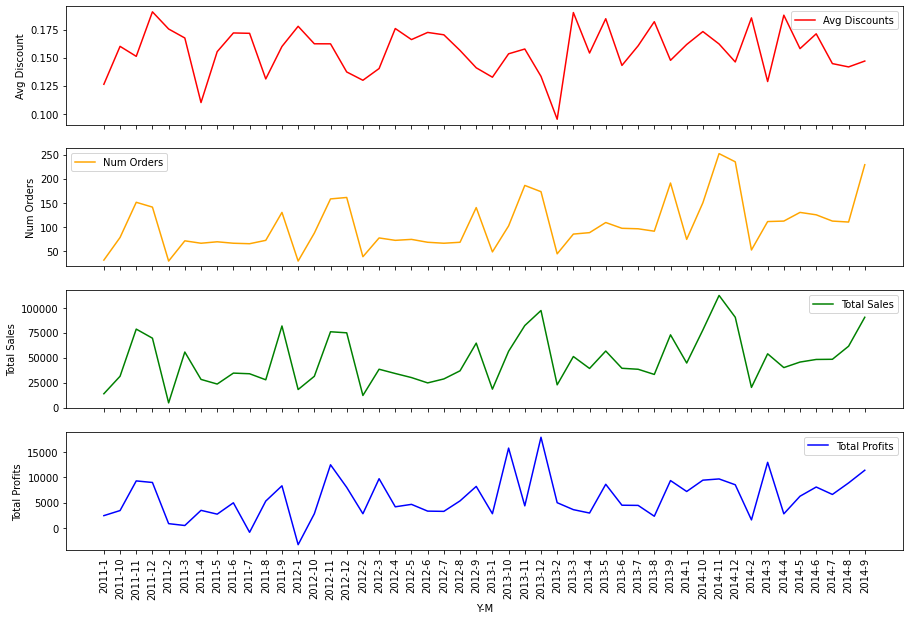

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 10))
sns.lineplot(data=trend, x='Y-M', y='Avg Discount', label='Avg Discounts', ax=ax1, color='red');
sns.lineplot(data=trend, x='Y-M', y='Num Orders', label='Num Orders', ax=ax2, color='orange');
sns.lineplot(data=trend, x='Y-M', y='Total Sales', label='Total Sales', ax=ax3, color='green');
sns.lineplot(data=trend, x='Y-M', y='Total Profits', label='Total Profits', ax=ax4, color='blue');
plt.xticks(rotation=90);

In [14]:
trend.loc[trend['Total Profits'] <= 0]

,Y-M,Y-Q,Num Orders,Total Sales,Avg Discount,Total Profits
9,2011-7,2011-Q3,65,33946.3930,0.171678,-841.4826
12,2012-1,2012-Q1,29,18174.0756,0.177931,-3281.0070


### Story 2. Under months when total profits were negative, certain categories had big losses

In [15]:
df.loc[df['Order Y-M'].isin(['2011-7'])].groupby(['Category', 'Sub-Category'])[['Discount', 'Profit']].agg({'Discount':lambda x: round(np.mean(x)*100, 2), 'Profit':'mean'})

Discount      Profit
Category        Sub-Category                      
Furniture       Bookcases         7.50  133.469300
                Chairs           19.23   -0.367415
                Furnishings      18.33   14.222592
                Tables           21.67   -9.764433
Office Supplies Appliances       45.00   -2.692900
                Art               6.67    4.979633
                Binders          38.33 -149.736683
                Envelopes        20.00   23.095800
                Fasteners        13.33    2.813067
                Labels            0.00   22.974225
                Paper             7.06   20.397029
                Storage          10.77   17.353246
                Supplies          0.00  114.603267
Technology      Accessories       6.15   39.891769
                Copiers          20.00  174.997500
                Phones           15.71   40.906957

In [16]:
df.loc[df['Order Y-M'].isin(['2012-1'])].groupby(['Category', 'Sub-Category'])[['Discount', 'Profit']].agg({'Discount':lambda x: round(np.mean(x)*100, 2), 'Profit':'mean'})

Discount      Profit
Category        Sub-Category                      
Furniture       Bookcases        41.00 -340.931700
                Chairs           25.00  -17.516400
                Furnishings      10.00   -2.247200
                Tables           36.67 -749.595933
Office Supplies Appliances        0.00   34.675200
                Art               8.57    5.104943
                Binders          21.67   12.829767
                Envelopes         0.00    8.215600
                Labels            6.67    6.854400
                Paper             6.00   22.586450
                Storage           0.00   71.591000
                Supplies         20.00   10.008000
Technology      Accessories      20.00   30.448600
                Machines         45.00 -367.201350
                Phones           40.00  -35.607833

### Story 3. To find out Discount set up for each category, we need to check the correlation between discount and profit based on sales history

<AxesSubplot:xlabel='Discount', ylabel='Profit'>

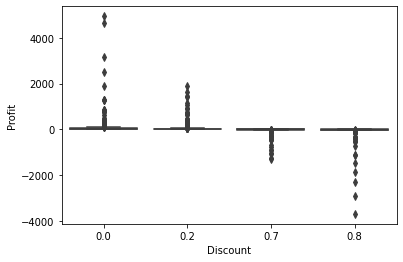

In [20]:
sns.boxplot(data=df.loc[df['Sub-Category'] == 'Binders'], x='Discount', y='Profit')

<AxesSubplot:xlabel='Discount', ylabel='Profit'>

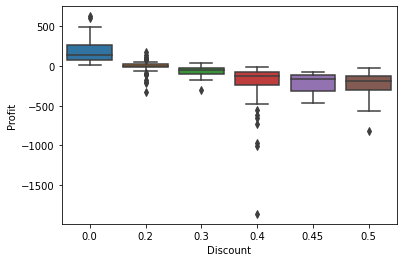

In [18]:
sns.boxplot(data=df.loc[df['Sub-Category'] == 'Tables'], x='Discount', y='Profit')

<AxesSubplot:xlabel='Discount', ylabel='Profit'>

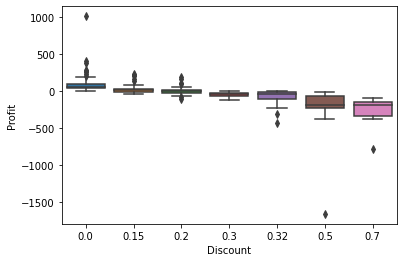

In [19]:
sns.boxplot(data=df.loc[df['Sub-Category'] == 'Bookcases'], x='Discount', y='Profit')

<AxesSubplot:xlabel='Discount', ylabel='Profit'>

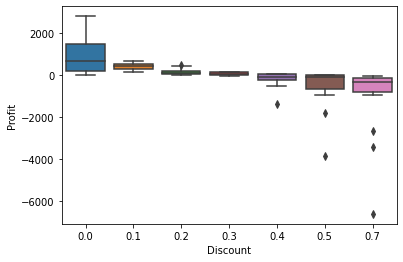

In [21]:
sns.boxplot(data=df.loc[df['Sub-Category'] == 'Machines'], x='Discount', y='Profit')